In [1]:
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
import time

## Transform the data

In [2]:
# CONFIG
DATA_PATH = "/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data"
SNAPSHOT_PATH = f"{DATA_PATH}/snapshot_data"
OPTION_TRADES_PATH = f"{DATA_PATH}/option_trade_data"
SPOT_DATA_PATH = f"{DATA_PATH}/spot_data"
DTE_PATH = f"{DATA_PATH}/DTE_data"

In [3]:
# TRANSFORM OPTION SNAPSHOT DATA
def transform_data():
    coins = ["btc", "eth"]
    columns = [
        "timestamp", "local_timestamp", "symbol", "type", "expiration", "time_to_mat", "coin", "strike", "opt_type", "spot",
        "bid_price", "ask_price", "mark_price", "bid_iv", "ask_iv", "mark_iv",
        "delta", "gamma", "vega", "theta", "rho", "open_interest", "volume"
    ]

    for coin in coins:
        # Load raw JSON
        data = pd.read_json(f"{SNAPSHOT_PATH}/{coin}_full_data.json")

        # Unpack data into rows
        rows = []
        for symbol, row in data.iterrows():
            for timestamp, quote in row.items():
                if isinstance(quote, dict):
                    entry = {col: quote.get(col, np.nan) for col in columns}
                    rows.append(entry)

        # Create DataFrame
        df = pd.DataFrame(rows)

        # Type casting
        df["local_timestamp"] = df["local_timestamp"].astype("int64")
        df["timestamp"] = df["timestamp"].astype("int64")
        df["time_to_mat"] = (df["expiration"] - df["timestamp"]).astype("float64")
        df["DTE"] = np.floor(df["time_to_mat"] / 86400)
        df["symbol"] = df["symbol"].astype("str")
        df["type"] = df["type"].astype("str")
        df["expiration"] = df["expiration"].astype("int64")
        df["strike"] = df["strike"].astype("float")
        df["opt_type"] = df["opt_type"].astype("str")
        df["coin"] = df["coin"].astype("str")
        df["spot"] = df["spot"].astype("float")

        greek_cols = ["delta", "gamma", "vega", "theta", "rho",
                      "bid_price", "ask_price", "mark_price",
                      "bid_iv", "ask_iv", "mark_iv", "open_interest", "volume"]
        for col in greek_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        # Save transformed CSV
        df.to_csv(f"{SNAPSHOT_PATH}/{coin}_full_data_transformed.csv", index=False)

# ----------------------------------------
# MAIN ENTRYPOINT
# ----------------------------------------
def main():
    transform_data()

# Run if script is executed
if __name__ == "__main__":
    main()

## Create spot data

In [4]:
# FETCH BINANCE OHLCV DATA
def fetch_all_ohlcv(timeframe='1m', limit=1000):
    symbols = ['BTCUSDT', 'ETHUSDT']
    for symbol in symbols:
        exchange = ccxt.binance()
        since = exchange.parse8601('2021-09-01T00:00:00Z')
        until = exchange.parse8601('2022-10-01T00:00:00Z')
        all_candles, now = [], since
        
        while now < until:
            candles = exchange.fetch_ohlcv(symbol, timeframe, since=now, limit=limit)
            if not candles:
                break
            all_candles.extend(candles)

            last_timestamp = candles[-1][0]
            now = last_timestamp + 1
            time.sleep(exchange.rateLimit / 1000)

        df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df.to_csv(f"{DATA_PATH}/{symbol}_1m_OHLCV.csv", index=False)

# ----------------------------------------
# MAIN ENTRYPOINT
# ----------------------------------------
def main():
    fetch_all_ohlcv()

# Run if script is executed
if __name__ == "__main__":
    main()

## Make some data adjustments

In [5]:
# FILTER 0DTE OPTIONS
def get_0dte():
    coins = ['btc', 'eth']
    for coin in coins:
        df = pd.read_csv(f"{SNAPSHOT_PATH}/{coin}_full_data_transformed.csv")
        df_0dte = df[df["DTE"] == 0]
        df_0dte.to_csv(f"{DATA_PATH}/{coin}_0DTE.csv", index=False)

# MERGE OHLCV WITH OPTION SNAPSHOT
def merge_on_timestamp():
    symbols = ['ETHUSDT', 'BTCUSDT']
    for symbol in symbols:
        coin = symbol.replace('USDT','')

        # Load OHLCV
        spot_df = pd.read_csv(f"{DATA_PATH}/{symbol}_1m_OHLCV.csv")
        spot_df['timestamp'] = spot_df['timestamp']
        spot_df['timestamp_minute'] = pd.to_datetime(spot_df['timestamp'], unit='ms').dt.floor('min')
        spot_df = spot_df.drop_duplicates(subset='timestamp').sort_values('timestamp')

        # Load options
        df_options = pd.read_csv(f"{SNAPSHOT_PATH}/{coin}_full_data_transformed.csv")
        df_options = df_options.sort_values('timestamp')
        df_options['local_minute'] = pd.to_datetime(df_options['local_timestamp'], unit='us').dt.floor('min')

        # Merge
        df_merged = df_options.merge(
            spot_df[['timestamp_minute','close']].rename(columns={'close':'spot_close'}),
            left_on='local_minute',
            right_on='timestamp_minute',
            how='left'
        )

        # Show result
        print(f"\n--- Merged data for {symbol} ---")
        print(df_merged[['timestamp','symbol','spot','spot_close']].head())

        # Optionally save merged result:
        df_merged.to_csv(f"{DATA_PATH}/{coin}_full_data_merged.csv", index=False)

# ----------------------------------------
# MAIN ENTRYPOINT
# ----------------------------------------
def main():
    get_0dte()
    merge_on_timestamp()

# Run if script is executed
if __name__ == "__main__":
    main()



--- Merged data for ETHUSDT ---
    timestamp              symbol     spot  spot_close
0  1630972800  ETH-10SEP21-4800-C  3936.15     3925.55
1  1630972800  ETH-29OCT21-1400-P  4004.07     3925.55
2  1630972800  ETH-17SEP21-3400-P  3947.41     3925.55
3  1630972800   ETH-8SEP21-4000-C  3931.52     3925.55
4  1630972800  ETH-17SEP21-2900-P  3947.41     3925.55

--- Merged data for BTCUSDT ---
    timestamp                symbol     spot  spot_close
0  1630972800    BTC-7SEP21-54000-C  52559.5    52658.84
1  1630972800  BTC-24SEP21-200000-P  52559.5    52658.84
2  1630972800   BTC-24SEP21-34000-C  52559.5    52658.84
3  1630972800   BTC-17SEP21-52000-P  52559.5    52658.84
4  1630972800   BTC-17SEP21-56000-P  52559.5    52658.84


## Get plots

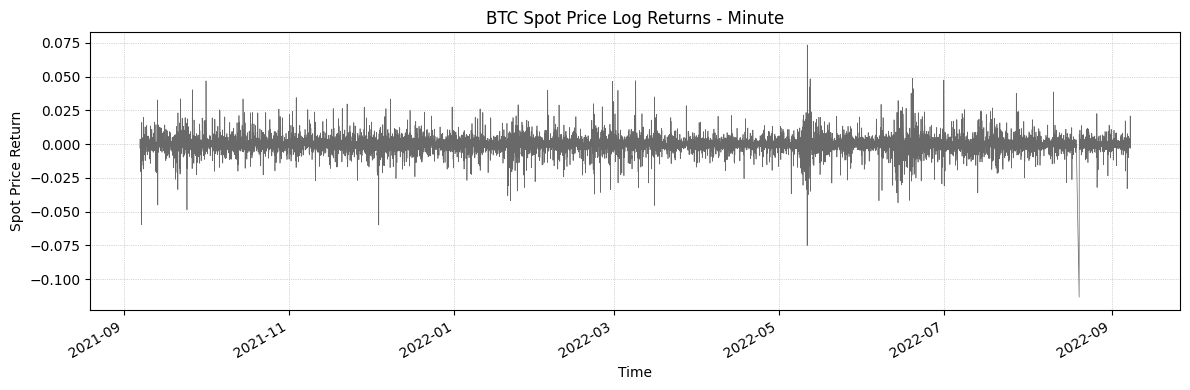

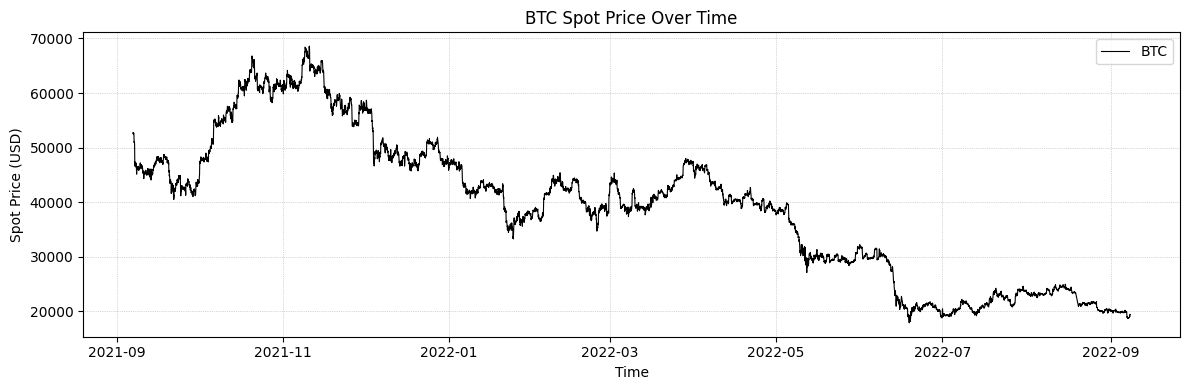

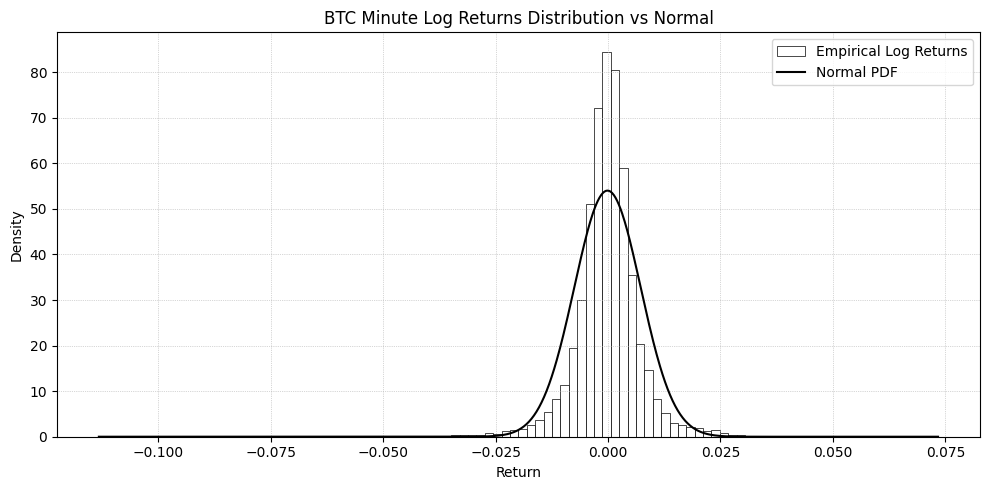

BTC Skewness: -0.50
BTC Kurtosis: 14.79 (Normal = 3)


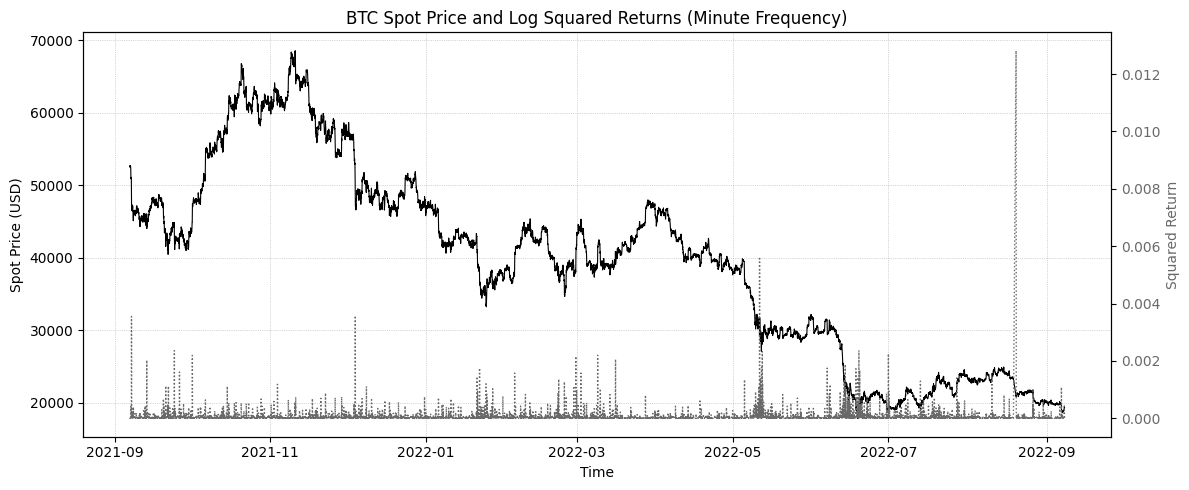

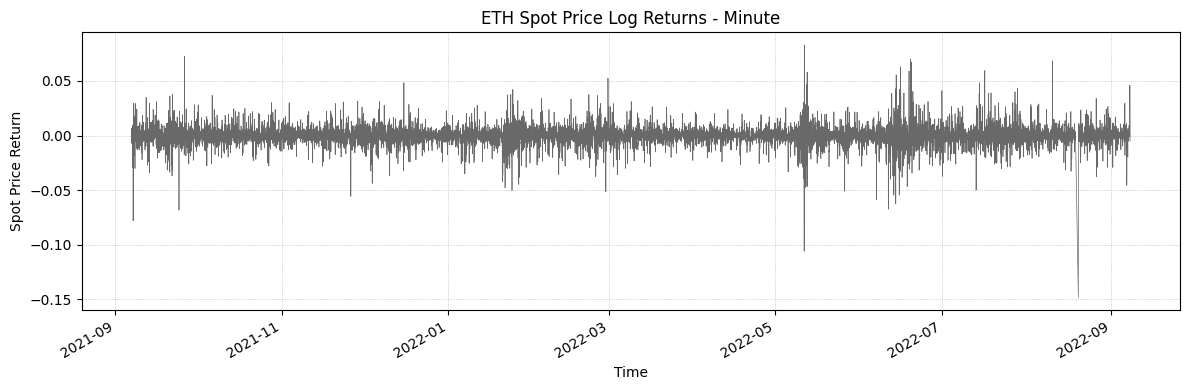

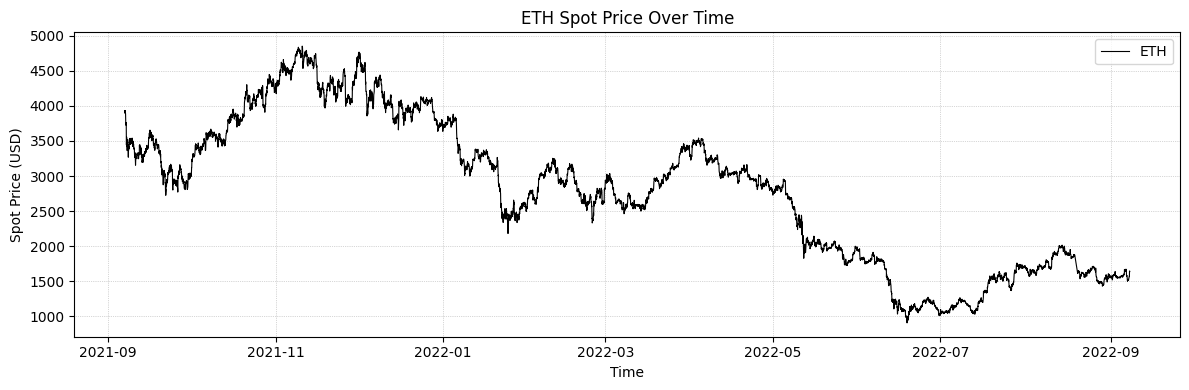

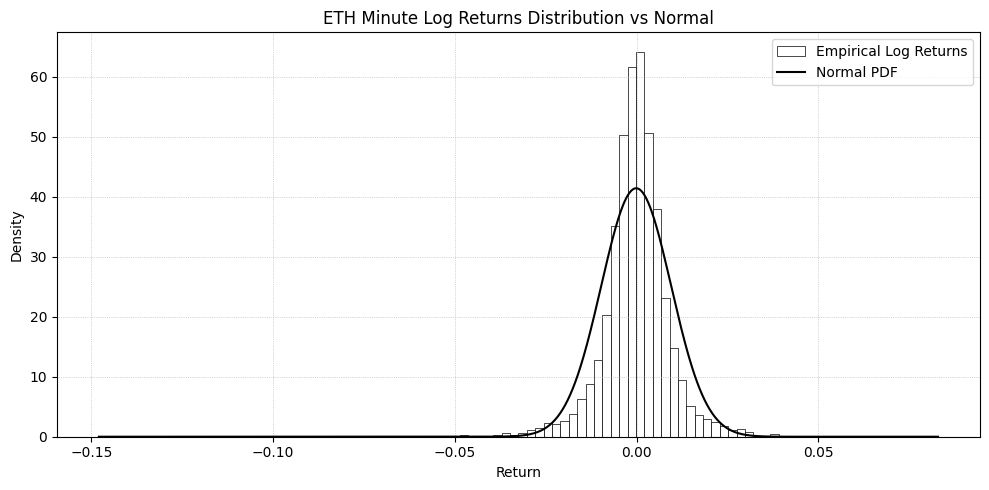

ETH Skewness: -0.55
ETH Kurtosis: 14.83 (Normal = 3)


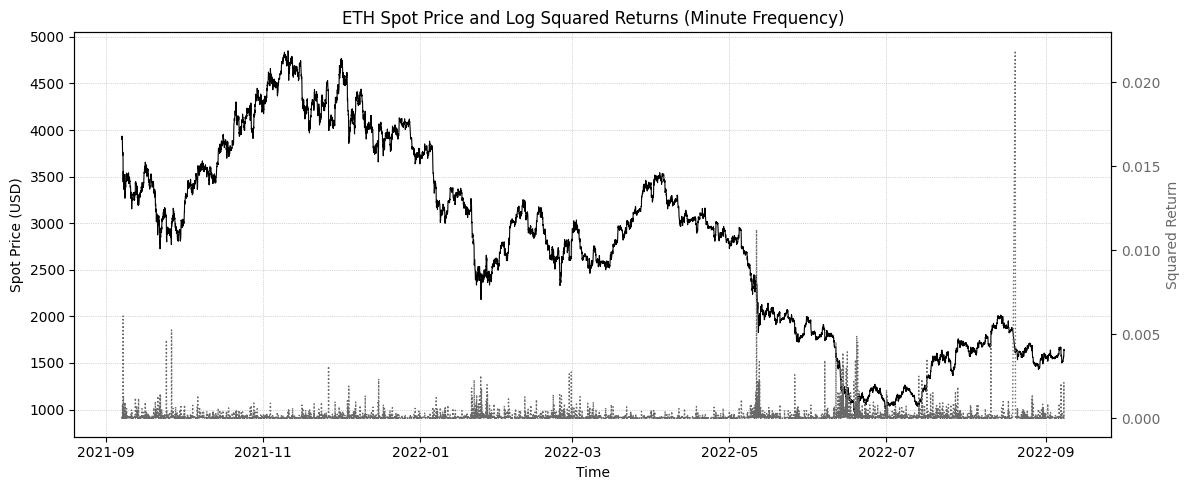

In [6]:
coins = ['BTC', 'ETH']
for coin in coins:
    # Load merged data
    df = pd.read_csv(f"{SNAPSHOT_PATH}/{coin}_full_data_merged.csv")

    # Convert timestamp_minute to datetime for plotting
    df['timestamp_minute'] = pd.to_datetime(df['timestamp_minute'])

    # Use spot_close as spot price
    spot_per_time = df.groupby('timestamp_minute')['spot_close'].first()

    # Compute log returns
    spot_log_return = np.log(spot_per_time).diff().dropna()

    # Plot log returns
    spot_log_return.plot(
        figsize=(12, 4), 
        color='dimgray',  
        linewidth=0.5,
        title=f"{coin} Spot Price Log Returns - Minute"
    )   

    plt.xlabel("Time")
    plt.ylabel("Spot Price Return")
    plt.grid(True, linestyle=':', linewidth=0.5)   
    plt.tight_layout()
    plt.show()
    
    # Plot spot price
    plt.figure(figsize=(12, 4))
    plt.plot(spot_per_time, label=coin, linewidth=0.8, color='black')
    plt.title(f"{coin} Spot Price Over Time")
    plt.xlabel("Time")
    plt.ylabel("Spot Price (USD)")
    plt.grid(True, linestyle=':', linewidth=0.5)    
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Histogram vs normal
    mu = spot_log_return.mean()
    sigma = spot_log_return.std()

    plt.figure(figsize=(10, 5))
    plt.hist(
        spot_log_return, 
        bins=100, 
        density=True, 
        alpha=1.0, 
        color='white',   
        edgecolor='black', 
        linewidth=0.5,
        label='Empirical Log Returns'
    )

    x = np.linspace(spot_log_return.min(), spot_log_return.max(), 1000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color='black', lw=1.5, linestyle='-', label='Normal PDF')  

    plt.title(f"{coin} Minute Log Returns Distribution vs Normal")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Skewness and kurtosis
    print(f"{coin} Skewness: {spot_log_return.skew():.2f}")
    print(f"{coin} Kurtosis: {spot_log_return.kurtosis():.2f} (Normal = 3)")

    # Plot spot vs squared log returns
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot spot price on left y-axis
    ax1.plot(spot_per_time, color='black', linewidth=0.8, label='Spot Price')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Spot Price (USD)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, linestyle=':', linewidth=0.5)

    # Create second y-axis for squared returns
    ax2 = ax1.twinx()
    spot_log_return_squared = spot_log_return ** 2

    ax2.plot(spot_log_return_squared, color='dimgray', linestyle='dotted', linewidth=1, label='Log Squared Returns')
    ax2.set_ylabel('Squared Return', color='dimgray')
    ax2.tick_params(axis='y', labelcolor='dimgray')

    plt.title(f"{coin} Spot Price and Log Squared Returns (Minute Frequency)")
    fig.tight_layout()
    plt.show()


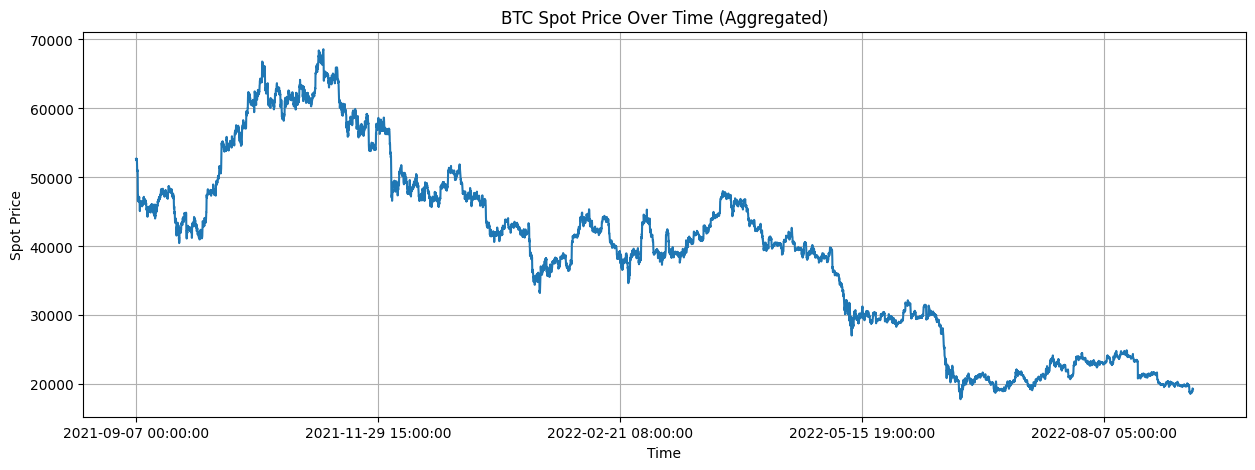

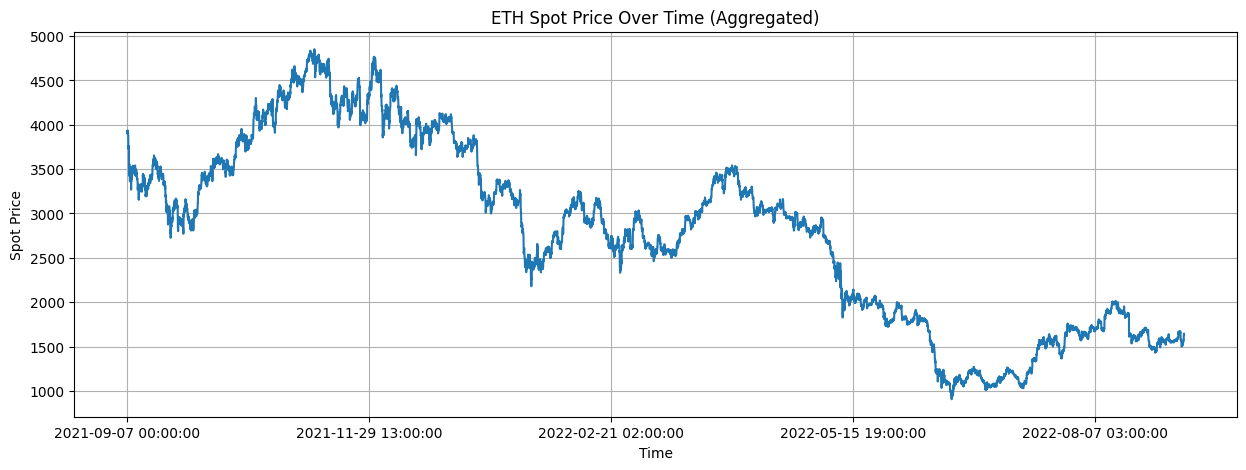

In [7]:
# Load data
df_btc = pd.read_csv("/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/snapshot_data/BTC_full_data_merged.csv")
spot_per_time = df_btc.groupby('timestamp_minute')['spot_close'].first()

# Plot
spot_per_time.plot(figsize=(15,5), title='BTC Spot Price Over Time (Aggregated)')
plt.xlabel('Time')
plt.ylabel('Spot Price')
plt.grid(True)
plt.show()

# Load data
df_eth = pd.read_csv("/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/snapshot_data/ETH_full_data_merged.csv")
spot_per_time = df_eth.groupby('timestamp_minute')['spot_close'].first()

# Plot
spot_per_time.plot(figsize=(15,5), title='ETH Spot Price Over Time (Aggregated)')
plt.xlabel('Time')
plt.ylabel('Spot Price')
plt.grid(True)
plt.show()



## Get Implied Volatility Surfaces and Visualize the Skew

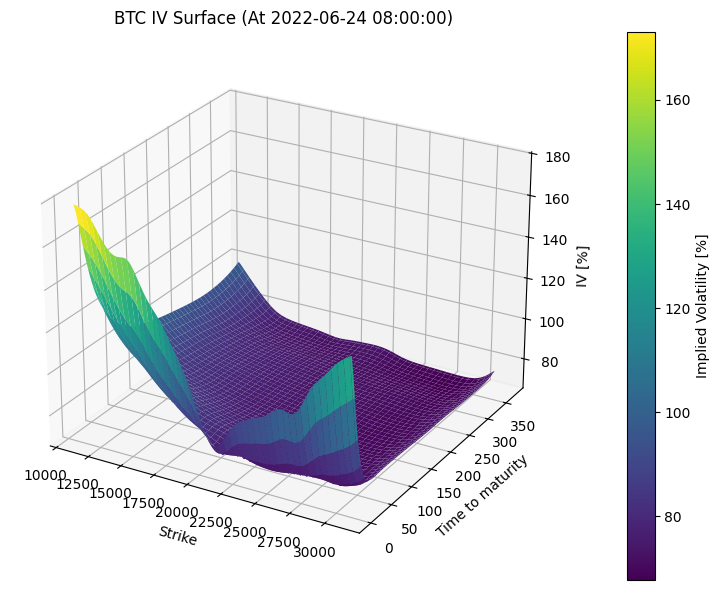

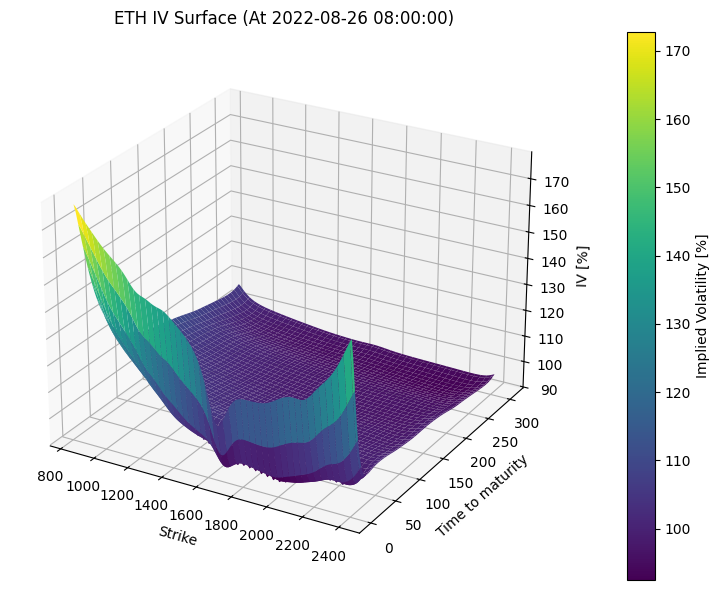

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from scipy.ndimage import gaussian_filter

def plot_iv_surface_for_best_minute(
    df, coin,
    grid_k=140, grid_t=90,
    rbf_fun='multiquadric', rbf_smooth=1.0, gauss_sigma=0.8
):
    # ── 1. ensure datetime column ───────────────────────────────────────────
    if df['timestamp_minute'].dtype != 'datetime64[ns]':
        df['timestamp_minute'] = pd.to_datetime(df['timestamp_minute'], unit='s')
    df['timestamp_minute'] = df['timestamp_minute'].dt.floor('min')

    # ── 2. pick busiest minute ──────────────────────────────────────────────
    best  = df['timestamp_minute'].value_counts().idxmax()
    delta = pd.Timedelta(minutes=5)
    start = best - delta
    end   = best + delta

    win = df[df['timestamp_minute'].between(start, end)]          # ← safe

    # ── 3. clean & filter ───────────────────────────────────────────────────
    win = win.query('spot_close>0 & mark_iv>0 & strike>0 & DTE>=0')
    s0  = win.spot_close.median()
    win = win.query('strike.between(@s0*0.5, @s0*1.5)')

    if len(win) < 30:
        print(f'{coin}: only {len(win)} points → skip')
        return

    # ---------- 2. raw arrays ----------
    x, y, z = win.strike.values, win.DTE.values, win.mark_iv.values

    # ---------- 3. scale axes (keeps RBF well-conditioned) ----------
    x̄, σx   = x.mean(), x.std()
    ȳ, σy   = y.mean(), y.std()
    xs, ys  = (x-x̄)/σx, (y-ȳ)/σy            # scaled
    k_grid  = np.linspace(x.min(), x.max(), grid_k)
    t_grid  = np.linspace(y.min(), y.max(), grid_t)
    K, T    = np.meshgrid(k_grid, t_grid)
    Ks, Ts  = (K-x̄)/σx, (T-ȳ)/σy            # same scaling

    # ---------- 4. RBF fit ----------
    rbf = Rbf(xs, ys, z, function=rbf_fun, smooth=rbf_smooth)
    IV  = rbf(Ks, Ts)

    # ---------- 5. OPTIONAL: Gaussian blur ----------
    if gauss_sigma:
        IV = gaussian_filter(IV, sigma=gauss_sigma)

    IV = np.clip(IV, 0, 300)                 # sane bounds

    # ---------- 6. plot ----------
    fig = plt.figure(figsize=(9, 6))
    ax  = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        K, T, IV,
        cmap='viridis',
        edgecolor='none',      # <- no wireframe
        antialiased=True
    )
    fig.colorbar(surf, pad=0.08, label='Implied Volatility [%]')
    ax.set(
        xlabel='Strike', ylabel='Time to maturity', zlabel='IV [%]',
        title=f'{coin.upper()} IV Surface (At {best})'
    )
    ax.view_init(elev=25, azim=-60)
    plt.tight_layout()
    plt.show()

cols = ['timestamp_minute', 'strike', 'DTE', 'mark_iv', 'spot_close', 'volume']

for coin in ['BTC', 'ETH']:
    df = pd.read_csv(
        f'{SNAPSHOT_PATH}/{coin}_full_data_merged.csv',
        usecols=cols,
        parse_dates=['timestamp_minute']
    )
    plot_iv_surface_for_best_minute(df, coin)

In [9]:
btc_0dte = pd.read_csv('/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/btc_0DTE.csv')
eth_0dte = pd.read_csv('/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/eth_0DTE.csv')

btc_0dte.shape[0], eth_0dte.shape[0]

(83537, 98036)